In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Dataset paths
dataset_path = "/content/drive/MyDrive/Concrete Crack Images for Classification"
positive_dir = f"{dataset_path}/Positive"
negative_dir = f"{dataset_path}/Negative"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from scipy.fftpack import fft2, ifft2, fftshift

In [4]:
# Create DataFrame from image paths
def generate_df(image_dir, label):
    filepaths = pd.Series(list(Path(image_dir).glob("*.jpg")), name="Filepath").astype(str)
    labels = pd.Series(label, name="Label", index=filepaths.index)
    return pd.concat([filepaths, labels], axis=1)

positive_df = generate_df(positive_dir, "POSITIVE")
negative_df = generate_df(negative_dir, "NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
train_df, test_df = train_test_split(all_df.sample(6000, random_state=1), train_size=0.7, random_state=1)

In [5]:
# Image preprocessing with Fourier Transform and PCA
def preprocess_image(path):
    img = imread(path, as_gray=True)
    img = resize(img, (120, 120))

    # Apply FFT
    freq_img = fftshift(fft2(img))
    magnitude = np.abs(freq_img)
    enhanced = np.log(1 + magnitude)

    # Normalize
    norm_img = (enhanced - np.min(enhanced)) / (np.max(enhanced) - np.min(enhanced))
    return norm_img

In [6]:
# Create DataFrame from image paths
def generate_df(image_dir, label):
    filepaths = pd.Series(list(Path(image_dir).glob("*.jpg")), name="Filepath").astype(str)
    labels = pd.Series(label, name="Label", index=filepaths.index)
    return pd.concat([filepaths, labels], axis=1)

positive_df = generate_df(positive_dir, "POSITIVE")
negative_df = generate_df(negative_dir, "NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
train_df, test_df = train_test_split(all_df.sample(6000, random_state=1), train_size=0.7, random_state=1)

In [7]:
# Image preprocessing with Fourier Transform and PCA
def preprocess_image(path):
    img = imread(path, as_gray=True)
    img = resize(img, (120, 120))

    # Apply FFT
    freq_img = fftshift(fft2(img))
    magnitude = np.abs(freq_img)
    enhanced = np.log(1 + magnitude)

    # Normalize
    norm_img = (enhanced - np.min(enhanced)) / (np.max(enhanced) - np.min(enhanced))
    return norm_img

In [8]:
# Prepare data arrays
def prepare_data(df):
    images = np.array([preprocess_image(p) for p in df['Filepath']])
    labels = np.array([1 if lbl == 'POSITIVE' else 0 for lbl in df['Label']])
    return images, labels

X_train, y_train = prepare_data(train_df)
X_test, y_test = prepare_data(test_df)

# Flatten for PCA
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Apply PCA to reduce noise
pca = PCA(n_components=200)  # Reduce to 200 components
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

# Reshape back to image format
X_train_img = X_train_pca.reshape(-1, 10, 20, 1)
X_test_img = X_test_pca.reshape(-1, 10, 20, 1)

In [9]:
# Build CNN model
inputs = tf.keras.Input(shape=(10, 20, 1))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 20, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 8, 18, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 2, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,041 (90.00 KB)

 Trainable params: 23,041 (90.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train model
history = model.fit(
    X_train_img, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Evaluate
results = model.evaluate(X_test_img, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f} | Test Accuracy: {results[1]*100:.2f}%")

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6236 - loss: 0.5845 - val_accuracy: 0.9524 - val_loss: 0.2064
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9382 - loss: 0.1812 - val_accuracy: 0.9452 - val_loss: 0.1580
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9511 - loss: 0.1367 - val_accuracy: 0.9571 - val_loss: 0.1586
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9613 - loss: 0.1096 - val_accuracy: 0.9548 - val_loss: 0.1316
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9596 - loss: 0.1093 - val_accuracy: 0.9667 - val_loss: 0.1211
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9594 - loss: 0.1018 - val_accuracy: 0.9667 - val_loss: 0.1145
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9595 - loss: 0.1038 - val_accuracy: 0.9667 - val_loss: 0.1108
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9617 - loss: 0.0981 - val_accuracy: 0

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


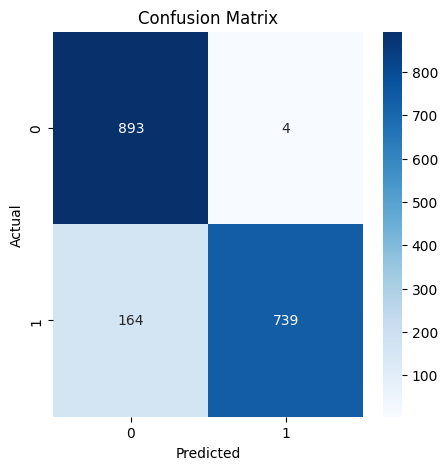

Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.84      1.00      0.91       897
    POSITIVE       0.99      0.82      0.90       903

    accuracy                           0.91      1800
   macro avg       0.92      0.91      0.91      1800
weighted avg       0.92      0.91      0.91      1800



In [11]:
# Predict
y_pred = (model.predict(X_test_img) >= 0.5).astype(int).squeeze()
cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=["NEGATIVE", "POSITIVE"])

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", clr)

In [12]:
# # Predictions
# y_pred = (model.predict(test_data) >= 0.5).astype(int).squeeze()
# cm = confusion_matrix(test_data.labels, y_pred)
# clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])

In [13]:
# # Confusion Matrix Plot
# plt.figure(figsize=(5, 5))
# sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

# print("Classification Report:\n", clr)

In [14]:
# # Save model
# model.save("toeplitz_crack_model.h5")